In [41]:
# Load libraries
from sklearn import model_selection
import os
import warnings
import time
import random as rnd
import scipy.io
from sklearn.svm import SVR
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
# import joblib
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib import rc
import pandas
import seaborn as sn
# ignore all warnings
warnings.filterwarnings("ignore")

# ===========================================================================
# Here starts the main part of the script
#

In [42]:
def logistic_func(X1, bayta1, bayta2, bayta3, bayta4):
    logisticPart = 1 + np.exp(np.negative(np.divide(X1 - bayta3, np.abs(bayta4))))
    yhat = bayta2 + np.divide(bayta1 - bayta2, logisticPart)
    return yhat

In [43]:
def curve_bounds(x, params, sigma):
    upper_bound = logistic_func(x, params[0] + 2 * sigma[0], params[1] + 2 * sigma[1], params[2] + 2 * sigma[2], params[3] + 2 * sigma[3])
    lower_bound = logistic_func(x, params[0] - 2 * sigma[0], params[1] - 2 * sigma[1], params[2] - 2 * sigma[2], params[3] + 2 * sigma[3])
    return upper_bound, lower_bound

In [44]:
pred_option = 'one'
pred_option

'one'

# pred_MOS_one

In [45]:
if pred_option == 'one':
    '''======================== parameters ================================'''
    model_name = 'SVR'

    resolution_op = '/all/' #'/resolution/', '/all/'
    model_path = '../model' + resolution_op
    fig_path = '../fig' #+ resolution_op

    data_split = False
    algo_name1 = 'NSS_CNN'
    f'data_split: {data_split}'

In [46]:
if pred_option == 'one':
    if data_split == True:
        data_name = 'YOUTUBE_UGC_360P'
        train_data = 'train_' + data_name   # 'train_KONVID_1K/train_YOUTUBE_UGC_ALL/train_COMBINED'
        test_data = 'test_' + data_name   # 'test_KONVID_1K/test_YOUTUBE_UGC_ALL/test_COMBINED'
        resolution_name = 'test_' + data_name   # 'KONVID_1K/YOUTUBE_UGC_ALL/COMBINED'

        # read npy for train_test_split
        npy_feats_test1 = np.load('../train_test' + resolution_op + test_data + '_' + algo_name1 + '_'  + 'feats.npy', allow_pickle=True)
        npy_scores_test1 = np.load('../train_test' + resolution_op + test_data + '_' + algo_name1 + '_' + 'scores.npy', allow_pickle=True)
        try:
            video_name1 = npy_scores_test1[:, 0]
            mos1 = npy_scores_test1[:, 1]
        except:
            raise Exception('Read npy file error!')
        '''======================== read files =============================== '''
        X1 = npy_feats_test1
        X1[np.isnan(X1)] = 0
        X1[np.isinf(X1)] = 0
        print(f'mos: {len(mos1)}')

        # save model
        model_file1 = os.path.join(model_path, train_data + '_' + algo_name1 + '_trained_svr.pkl')
        scaler_file1 = os.path.join(model_path, train_data + '_' + algo_name1 + '_trained_scaler.pkl')
        pars_file1 = os.path.join(model_path, train_data + '_' + algo_name1 + '_logistic_pars.mat')

        print("Predict quality scores using pretrained {} with {} on split dataset {} ...".format(train_data + '_' + algo_name1 , model_name, test_data))

        '''======================== read saved model =============================== '''
        model1 = joblib.load(model_file1)
        scaler1 = joblib.load(scaler_file1)
        popt1 = np.asarray(scipy.io.loadmat(pars_file1)['popt'][0], dtype=np.float)

        X1 = scaler1.transform(X1)
        y_pred1 = model1.predict(X1)
        y1 = logistic_func(y_pred1, *popt1)
        # print('Predicted MOS in [1,5]:')
        # print(y1)

In [47]:
if pred_option == 'one':
    if data_split == False:
        # train on one dataset, test on the other one
        train_model_data = 'train_YOUTUBE_UGC_ALL' # 'train_KONVID_1K/train_YOUTUBE_UGC_ALL/train_COMBINED'
        test_data = 'KONVID_1K'  # 'KONVID_1K/YOUTUBE_UGC_ALL/COMBINED'
        resolution_name = 'KONVID_1K_testOn_YOUTUBE_UGC_ALL'  # 'KONVID_1K/YOUTUBE_UGC_ALL/COMBINED'

        # read mat file for all dataset
        csv_file = '../mos_file/' + test_data + '_metadata.csv'
        mat_file = os.path.join('../feat_file' + resolution_op, test_data + '_' + algo_name1 + '_feats.mat')
        print(mat_file)

        '''======================== read files =============================== '''
        X_mat = scipy.io.loadmat(mat_file)
        X1 = np.asarray(X_mat['feats_mat'], dtype=np.float)
        X1 = np.vstack((X1))
        X1[np.isnan(X1)] = 0
        X1[np.isinf(X1)] = 0

        if test_data == 'KONVID_1K':
            # read KONVID_1K
            df1 = pandas.read_csv(csv_file)
            video_name1 = df1['flickr_id'].tolist()
            mos1 = df1['mos'].tolist()

        elif test_data == 'YOUTUBE_UGC':
            # read YOUTUBE_UGC
            df3 = pandas.read_csv(csv_file)
            video_name1 = df3['vid'].tolist()
            mos1 = df3['MOSFull'].tolist()

        # save model
        model_file1 = os.path.join(model_path, train_model_data + '_' + algo_name1 + '_trained_svr.pkl')
        scaler_file1 = os.path.join(model_path, train_model_data + '_' + algo_name1 + '_trained_scaler.pkl')
        pars_file1 = os.path.join(model_path, train_model_data + '_' + algo_name1 + '_logistic_pars.mat')

        print("Predict quality scores using pretrained {} with {} on split dataset {} ...".format(train_model_data + '_' + algo_name1, model_name, test_data))

        '''======================== read saved model =============================== '''
        model1 = joblib.load(model_file1)
        scaler1 = joblib.load(scaler_file1)
        popt1 = np.asarray(scipy.io.loadmat(pars_file1)['popt'][0], dtype=np.float)

        X1 = scaler1.transform(X1)
        y_pred1 = model1.predict(X1)
        y1 = logistic_func(y_pred1, *popt1)
        # print('Predicted MOS in [1,5]:')
        # print(y1)

../feat_file/all/KONVID_1K_NSS_CNN_feats.mat
Predict quality scores using pretrained train_YOUTUBE_UGC_ALL_NSS_CNN with SVR on split dataset KONVID_1K ...


In [48]:
if pred_option == 'one':
    data = {'Video_name': video_name1,
            'MOS': mos1,
            'y_pred1': y_pred1,
            "Predicted Score_" + algo_name1: y1}
    result = pandas.DataFrame(data)

    result_path = '../result' + resolution_op + resolution_name + '_' + algo_name1 + '_Predicted_Score.csv'
    result.to_csv(result_path, index=False, header=True)

    mos1 = np.array(mos1, dtype=np.float64)
    y1 = np.array(y1, dtype=np.float64)
    print(result_path)
    # result

../result/all/KONVID_1K_testOn_YOUTUBE_UGC_ALL_NSS_CNN_Predicted_Score.csv


In [49]:
if pred_option == 'one':
    # scatter plot for one test dataset
    # nonlinear logistic fitted curve / logistic regression
    try:
        beta = [np.max(mos1), np.min(mos1), np.mean(y1), 0.5]
        popt, pcov = curve_fit(logistic_func, y1, mos1, p0=beta, maxfev=100000000)
        sigma = np.sqrt(np.diag(pcov))
    except:
        raise Exception('Fitting logistic function time-out!!')

=======================NSS_CNN===============================


'../fig/all/KONVID_1K_testOn_YOUTUBE_UGC_ALL_NSS_CNN.png'

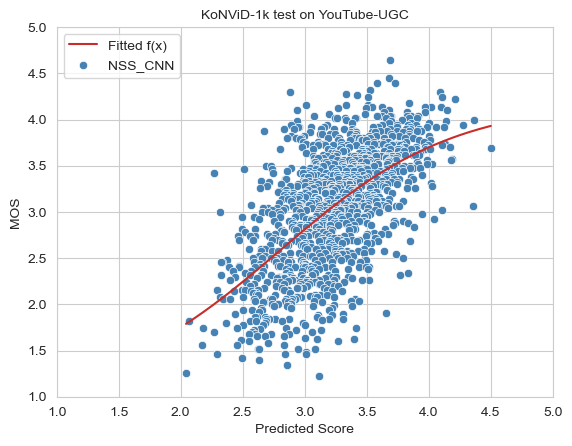

In [50]:
if data_split == True:
    if data_name == 'YOUTUBE_UGC_ALL':
        title_name = 'YouTube-UGC'
    elif data_name == 'KONVID_1K':
        title_name = 'KoNViD-1k'
    else:
        title_name = data_name
else:
    if test_data == 'YOUTUBE_UGC_ALL':
        title_name = 'YouTube-UGC test on KoNViD-1k'
    elif test_data == 'KONVID_1K':
        title_name = 'KoNViD-1k test on YouTube-UGC'
    else:
        title_name = test_data

if pred_option == 'one':
    print('=======================' + algo_name1 + '===============================')
    fig_name = f'{fig_path}{resolution_op}{resolution_name}_{algo_name1}.png'

    x_values1 = np.linspace(np.min(y1), np.max(y1), len(y1))
    upper_bound, lower_bound = curve_bounds(x_values1, popt, sigma)
    plt.plot(x_values1, logistic_func(x_values1, *popt), '-', color='#c72e29', label='Fitted f(x)')
    # plt.plot(x_values1, upper_bound, 'b--', label='f(x)±2σ')
    # plt.plot(x_values1, lower_bound, 'b--', label='f(x)±2σ')
    fig1 = sn.scatterplot(x="Predicted Score_" + algo_name1, y="MOS", data=result, markers='o', color='steelblue', label=algo_name1)
    plt.legend(loc='upper left')
    plt.ylim(1, 5)
    plt.xlim(1, 5)

    plt.title(title_name, fontsize=10)
    plt.xlabel('Predicted Score')
    plt.ylabel('MOS')
    reg_fig1 = fig1.get_figure()
    reg_fig1.savefig(fig_name, dpi=400)
fig_name

In [51]:
if data_split == True:
    data_name = data_name
else:
    data_name = test_data

if pred_option == 'one':
    srcc = scipy.stats.spearmanr(mos1, y1)[0]
    krcc = scipy.stats.kendalltau(mos1, y1)[0]
    plcc = scipy.stats.pearsonr(mos1, y1)[0]
    rmse = np.sqrt(mean_squared_error(mos1, y1))

    correlation_name = f'{fig_path}/correlation/{data_name}_{algo_name1}_Correlaiton.csv'
    print(correlation_name)

    df_results = pd.DataFrame(columns=['DATASET PER RESOLUTION', 'MODEL', 'SRCC', 'KRCC', 'PLCC', 'RMSE'])
    df_results['DATASET PER RESOLUTION'] = [resolution_name]
    df_results['MODEL'] = [algo_name1]
    df_results['SRCC'] = [srcc]
    df_results['KRCC'] = [krcc]
    df_results['PLCC'] = [plcc]
    df_results['RMSE'] = [rmse]
    df_results.to_csv(correlation_name, index=None)
df_results

../fig/correlation/KONVID_1K_NSS_CNN_Correlaiton.csv


,DATASET PER RESOLUTION,MODEL,SRCC,KRCC,PLCC,RMSE
0,KONVID_1K_testOn_YOUTUBE_UGC_ALL,NSS_CNN,0.594876,0.423098,0.601268,0.549505


In [52]:
if pred_option == 'one':
    # random list
    rl = np.random.randint(len(mos1),size= int(len(mos1)*0.2))
    srcc_random = scipy.stats.spearmanr(mos1[rl],y1[rl])[0]
    krcc_random = scipy.stats.kendalltau(mos1[rl], y1[rl])[0]
    plcc_random = scipy.stats.pearsonr(mos1[rl], y1[rl])[0]
    rmse_random = np.sqrt(mean_squared_error(mos1[rl], y1[rl]))

    df_results = pd.DataFrame(columns=['DATASET PER RESOLUTION', 'MODEL', 'SRCC', 'KRCC', 'PLCC', 'RMSE'])
    df_results['DATASET PER RESOLUTION'] = [resolution_name]
    df_results['MODEL'] = [algo_name1]
    df_results['SRCC'] = [srcc_random]
    df_results['KRCC'] = [krcc_random]
    df_results['PLCC'] = [plcc_random]
    df_results['RMSE'] = [rmse_random]
df_results

,DATASET PER RESOLUTION,MODEL,SRCC,KRCC,PLCC,RMSE
0,KONVID_1K_testOn_YOUTUBE_UGC_ALL,NSS_CNN,0.549924,0.383239,0.535965,0.581699


# pred_MOS_compare

In [53]:
# if pred_option == 'compare':
#     '''======================== parameters ================================'''
#     model_name = 'SVR'
#
#     resolution_op = '/all/' #'/all/'
#     model_path = '../model' + resolution_op
#     fig_path = '../fig/compare/'
#
#     data_split = True
#     data_name = 'KONVID_1K'
#     algo_name1 = 'VSFACNN'
#     algo_name2 = 'VSFACNN_Saliency'
#     fig_op = 'ALL'

In [54]:
# if pred_option == 'compare':
#     if data_split == True:
#         train_data = 'train_' + data_name   # 'train_KONVID_1K/train_YOUTUBE_UGC_ALL/train_COMBINED'
#         test_data = 'test_' + data_name   # 'test_KONVID_1K/test_YOUTUBE_UGC_ALL/test_COMBINED'
#         resolution_name = 'test_' + data_name   # 'KONVID_1K/YOUTUBE_UGC_ALL/COMBINED'
#
#         # read npy for train_test_split
#         npy_feats_test1 = np.load('../train_test' + resolution_op + test_data + '_' + algo_name1 + '_' + 'feats.npy', allow_pickle=True)
#         npy_scores_test1 = np.load('../train_test' + resolution_op + test_data + '_' + algo_name1 + '_' + 'scores.npy', allow_pickle=True)
#         npy_feats_test2 = np.load('../train_test' + resolution_op + test_data + '_' + algo_name2 + '_' + 'feats.npy', allow_pickle=True)
#         npy_scores_test2 = np.load('../train_test' + resolution_op + test_data + '_' + algo_name2 + '_' + 'scores.npy', allow_pickle=True)
#         try:
#             video_name1 = npy_scores_test1[:, 0]
#             mos1 = npy_scores_test1[:, 1]
#             video_name2 = npy_scores_test2[:, 0]
#             mos2 = npy_scores_test2[:, 1]
#             if (video_name1 == video_name2).all():
#                 print('equal')
#                 video_name = video_name1 + '--' + video_name2
#             else:
#                 print('not equal')
#                 video_name = video_name1 + '--' + video_name2
#             if (mos1 == mos2).all():
#                 print('equal')
#                 mos = mos1 = mos2
#             else:
#                 print('not equal')
#         except:
#             raise Exception('Read npy file error!')
#         '''======================== read files =============================== '''
#         X1 = npy_feats_test1
#         X1[np.isnan(X1)] = 0
#         X1[np.isinf(X1)] = 0
#
#         X2 = npy_feats_test2
#         X2[np.isnan(X2)] = 0
#         X2[np.isinf(X2)] = 0
#
#         # save model
#         model_file1 = os.path.join(model_path, train_data + '_' + algo_name1 + '_trained_svr.pkl')
#         scaler_file1 = os.path.join(model_path, train_data + '_' + algo_name1 + '_trained_scaler.pkl')
#         pars_file1 = os.path.join(model_path, train_data + '_' + algo_name1 + '_logistic_pars.mat')
#
#         model_file2 = os.path.join(model_path, train_data + '_' + algo_name2 + '_trained_svr.pkl')
#         scaler_file2 = os.path.join(model_path, train_data + '_' + algo_name2 + '_trained_scaler.pkl')
#         pars_file2 = os.path.join(model_path, train_data + '_' + algo_name2 + '_logistic_pars.mat')
#
#         print("Predict quality scores using pretrained {} with {} on split dataset {} ...".format(train_data + '_' + algo_name1 , model_name, test_data))
#         print("Predict quality scores using pretrained {} with {} on split dataset {} ...".format(train_data + '_' + algo_name2, model_name, test_data))
#
#         '''======================== read saved model =============================== '''
#         model1 = joblib.load(model_file1)
#         scaler1 = joblib.load(scaler_file1)
#         popt1 = np.asarray(scipy.io.loadmat(pars_file1)['popt'][0], dtype=np.float)
#
#         model2 = joblib.load(model_file2)
#         scaler2 = joblib.load(scaler_file2)
#         popt2 = np.asarray(scipy.io.loadmat(pars_file2)['popt'][0], dtype=np.float)
#
#         # Algorithm 1
#         X1 = scaler1.transform(X1)
#         y_pred1 = model1.predict(X1)
#         y1 = logistic_func(y_pred1, *popt1)
#         # print('Predicted MOS in [1,5]:')
#         # print(y1)
#
#         # Algorithm 2
#         X2 = scaler2.transform(X2)
#         y_pred2 = model2.predict(X2)
#         y2 = logistic_func(y_pred2, *popt2)
#         # print('Predicted MOS in [1,5]:')
#         # print(y2)

In [55]:
# if pred_option == 'compare':
#     if data_split == False:
#         train_model_data = 'COMBINED'  # 'YOUTUBE_UGC_ALL/KONVID_1K/COMBINED'
#         test_data = 'KONVID_1K'     # 'KONVID_1K/YOUTUBE_UGC_ALL/COMBINED'
#         resolution_name = 'KONVID_1K_testOn_COMBINED'   # 'KONVID_1K/YOUTUBE_UGC_ALL/COMBINED'
#
#         # read mat file for all dataset
#         mat_file = os.path.join('../feat_file' + resolution_op, test_data + '_' + algo_name1 + '_feats.mat')
#         print(mat_file)
#         mat_ori = os.path.join('../feat_file' + resolution_op, test_data + '_' + algo_name2 + '_feats.mat')
#         print(mat_ori)
#         '''======================== read files =============================== '''
#         X_mat1 = scipy.io.loadmat(mat_file)
#         X1 = np.asarray(X_mat1['feats_mat'], dtype=np.float)
#         X1[np.isnan(X1)] = 0
#         X1[np.isinf(X1)] = 0
#
#         X_mat2 = scipy.io.loadmat(mat_ori)
#         X2 = np.asarray(X_mat2['feats_mat'], dtype=np.float)
#         X2[np.isnan(X2)] = 0
#         X2[np.isinf(X2)] = 0
#
#         # save model
#         model_file1 = os.path.join(model_path, train_model_data + '_' + algo_name1 + '_trained_svr.pkl')
#         scaler_file1 = os.path.join(model_path, train_model_data + '_' + algo_name1 + '_trained_scaler.pkl')
#         pars_file1 = os.path.join(model_path, train_model_data + '_' + algo_name1 + '_logistic_pars.mat')
#
#         model_file2 = os.path.join(model_path, train_model_data + '_' + algo_name2 + '_trained_svr.pkl')
#         scaler_file2 = os.path.join(model_path, train_model_data + '_' + algo_name2 + '_trained_scaler.pkl')
#         pars_file2 = os.path.join(model_path, train_model_data + '_' + algo_name2 + '_logistic_pars.mat')
#
#         print("Predict quality scores using pretrained {} with {} on dataset {} ...".format(train_model_data + '_' + algo_name1, model_name,
#                                                                                             test_data))
#         print("Predict quality scores using pretrained {} with {} on dataset {} ...".format(train_model_data + '_' + algo_name2, model_name,
#                                                                                             test_data))
#         '''======================== read saved model =============================== '''
#         model1 = joblib.load(model_file1)
#         scaler1 = joblib.load(scaler_file1)
#         popt1 = np.asarray(scipy.io.loadmat(pars_file1)['popt'][0], dtype=np.float)
#
#         model2 = joblib.load(model_file2)
#         scaler2 = joblib.load(scaler_file2)
#         popt2 = np.asarray(scipy.io.loadmat(pars_file2)['popt'][0], dtype=np.float)
#
#         # algorithm 1
#         X1 = scaler1.transform(X1)
#         y_pred1 = model1.predict(X1)
#         y1 = logistic_func(y_pred1, *popt1)
#         # print('Predicted MOS in [1,5]:')
#         # print(y1)
#
#         # algorithm 2
#         X2 = scaler2.transform(X2)
#         y_pred2 = model2.predict(X2)
#         y2 = logistic_func(y_pred2, *popt2)
#         # print('Predicted MOS in [1,5]:')
#         # print(y2)
#
#         if test_data == 'KONVID_1K':
#             csv_file = '../mos_file/' + test_data + '_metadata.csv'
#             try:
#                 d = pandas.read_csv(csv_file)
#                 video_name = d['flickr_id']
#                 mos = d['mos']
#             except:
#                 raise Exception('Read csv file error!')
#         elif test_data == 'YOUTUBE_UGC_ALL':
#             csv_file = '../mos_file/'+test_data+'_metadata.csv'
#             try:
#                 d = pandas.read_csv(csv_file)
#                 video_name = d['vid']
#                 mos = d['MOSFull']
#             except:
#                 raise Exception('Read csv file error!')

In [56]:
# if pred_option == 'compare':
#     data = {'Video_name': video_name,
#             'MOS1': mos1,
#             'y_pred1': y_pred1,
#             "Predicted Score_" + algo_name1: y1,
#             'MOS2': mos2,
#             'y_pred2': y_pred2,
#             "Predicted Score_" + algo_name2: y2}
#     result = pandas.DataFrame(data)
#
#     mos1 = np.array(mos1, dtype=np.float64)
#     mos2 = np.array(mos2, dtype=np.float64)
#     y1 = np.array(y1, dtype=np.float64)
#     y2 = np.array(y2, dtype=np.float64)

In [57]:
# if pred_option == 'compare':
#     if fig_op ==algo_name1:
#         print('=======================' + algo_name1 + '===============================')
#         # scatter plot for one test dataset
#         # nonlinear logistic fitted curve / logistic regression
#         try:
#             beta = [np.max(mos1), np.min(mos1), np.mean(y1), 0.5]
#             popt, pcov = curve_fit(logistic_func, y1, mos1, p0=beta, maxfev=100000000)
#             sigma = np.sqrt(np.diag(pcov))
#         except:
#             raise Exception('Fitting logistic function time-out!!')
#         x_values1 = np.linspace(np.min(y1), np.max(y1), len(y1))
#         upper_bound, lower_bound = curve_bounds(x_values1, popt, sigma)
#         plt.plot(x_values1, logistic_func(x_values1, *popt), '-', color='#c72e29', label='Fitted f(x)')
#         # plt.plot(x_values1, upper_bound, 'b--', label='f(x)±2σ')
#         # plt.plot(x_values1, lower_bound, 'b--', label='f(x)±2σ')
#         fig1 = sn.scatterplot(x="Predicted Score_" + algo_name1, y="MOS1", data=result, markers='o', color='steelblue', label=algo_name1)
#         plt.legend(loc='upper left')
#         plt.ylim(1, 5)
#         plt.xlim(1, 5)
#         plt.title(resolution_name, fontsize=10)
#         plt.xlabel('Predicted Score')
#         plt.ylabel('MOS')
#         reg_fig1 = fig1.get_figure()
#         reg_fig1.savefig(fig_path + resolution_name + '_' + algo_name1, dpi=400)

In [58]:
# if pred_option == 'compare':
#     if fig_op == algo_name2:
#         print('========================' + algo_name2 + '==============================')
#         # nonlinear logistic fitted curve / logistic regression
#         try:
#             beta = [np.max(mos2), np.min(mos2), np.mean(y2), 0.5]
#             popt, pcov = curve_fit(logistic_func, y2, mos2, p0=beta, maxfev=100000000)
#             sigma = np.sqrt(np.diag(pcov))
#         except:
#             raise Exception('Fitting logistic function time-out!!')
#         x_values2 = np.linspace(np.min(y2), np.max(y2), len(y2))
#         upper_bound, lower_bound = curve_bounds(x_values2, popt, sigma)
#         plt.plot(x_values2, logistic_func(x_values2, *popt), '-', color='#c72e29', label='Fitted f(x)')
#         # plt.plot(x_values2, upper_bound, 'b--', label='f(x)±2σ')
#         # plt.plot(x_values2, lower_bound, 'b--', label='f(x)±2σ')
#         fig2 = sn.scatterplot("Predicted Score_" + algo_name2, y="MOS2", data=result, markers='X', color='darkorange', label=algo_name2)
#         plt.legend(loc='upper left')
#         plt.ylim(1, 5)
#         plt.xlim(1, 5)
#         plt.title(resolution_name, fontsize=10)
#         plt.xlabel('Predicted Score')
#         plt.ylabel('MOS')
#         reg_fig2 = fig2.get_figure()
#         reg_fig2.savefig(fig_path + resolution_name + '_' + algo_name2, dpi=400)

In [59]:
# if pred_option == 'compare':
#     if fig_op == 'ALL':
#         print('=========================ALL=============================')
#         # scatter plot for two test dataset
#         sn.scatterplot(x="Predicted Score_" + algo_name1, y="MOS1", data=result, markers='X', color='darkorange', label=algo_name1)
#         # print(sorted(result["Predicted Score_" + algo_name2].tolist()))
#         fig = sn.scatterplot(x="Predicted Score_" + algo_name2, y="MOS2", data=result, markers='o', color='steelblue', label=algo_name2)
#         plt.legend(loc='upper left', title="Algorithm")
#         plt.ylim(1, 5)
#         plt.xlim(1, 5)
#         plt.title(resolution_name, fontsize=10)
#         plt.xlabel('Predicted Score')
#         plt.ylabel('MOS')
#         reg_fig = fig.get_figure()
#         reg_fig.savefig(fig_path + resolution_name + '_' + algo_name1 + '_vs_' + algo_name2, dpi=400)